
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries under a climate change scenario (future AWTs occurence probability & future TCs occurrence probability)

inputs required: 
  * Historical DWTs (for plotting)
  * Historical wave families (for plotting)
  * Synthetic DWTs ENSO climate change
  * Probability of TCs under climate change
  * Historical intradaily hydrograph parameters  
  * TCs waves
  * Fitted multivariate extreme model for the waves associated to each DWT

  
in this notebook:
  * Generate synthetic time series of wave conditions     

In the case of **waves associated to a TC event**, the associated simulated waves from WWIII simulation that have been reconstructed in notebook 07 are use whenever the simulated TC enters the 4 degrees radio. The probability of entering the 4 degree radio (from the 14 degree radio) is modified according to future changes under a climate change scenario


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies

from teslakit.plotting.outputs import Plot_FitSim_Histograms
from teslakit.plotting.extremes import Plot_FitSim_AnnualMax, Plot_FitSim_GevFit, Plot_Fit_QQ

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.climate_change import Plot_RCP_ocurrence



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database
p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'
# offshore
db = Database(p_data)
db.SetSite('GUAM')

# climate change - S5
db_S5 = Database(p_data)
db_S5.SetSite('GUAM_CC_S5')

# climate change - S6
db_S6 = Database(p_data)
db_S6.SetSite('GUAM_CC_S6')


# climate emulator simulation modified path
p_S6_CE_sims = op.join(db_S6.paths.site.EXTREMES.climate_emulator, 'Simulations')


In [3]:
# --------------------------------------
# Load data for climate emulator simulation climate change: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db_S5.Load_ESTELA_DWT_sim() # DWTs climate change

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = xr.open_dataset(op.join(p_data, 'sites/GUAM/TCs/TCs_sim_r2_RBF_output.nc'))  # TCs numerical-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])

# --------------------------------------
# Load climate change data

lon_rcp, lat_rcp, RCP85ratioHIST_occurrence = db.Load_RCP85()


In [4]:
# solve first 10 DWTs simulations

DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))
print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 365244)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 3000-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...
Attributes:
    source:   teslakit_v0.9.1


## Obtain future TCs occurence probability at the site

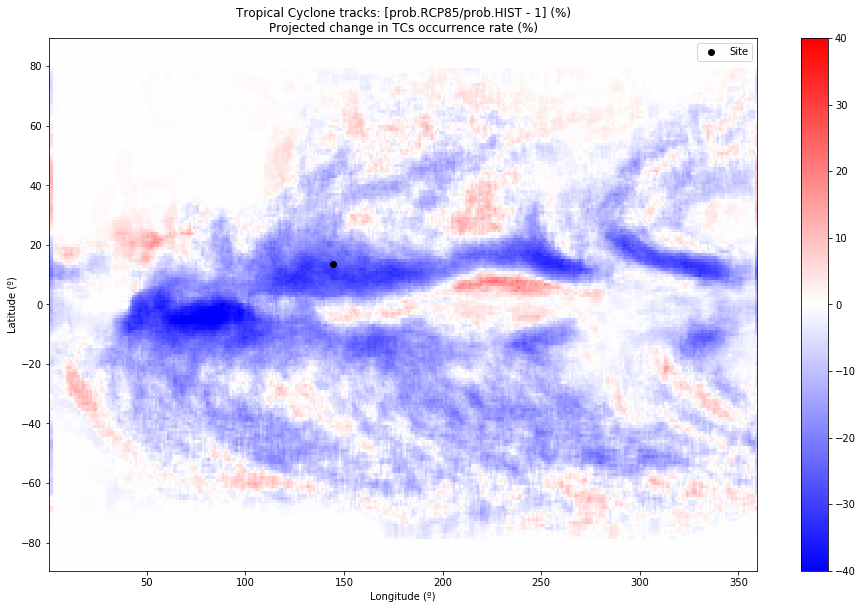

In [5]:
# Guam coordinates
lon_p = 144.75
lat_p = 13.44

# find closest point at RCP data
lon_g, lat_g = np.meshgrid(lon_rcp, lat_rcp)
dif = np.sqrt((lon_g - lon_p)**2 + (lat_g - lat_p)**2)
min_ind = np.where(dif == np.min(dif))
ix_lon, ix_lat = min_ind[0], min_ind[1]

# TCs ocurrence probability at site
TCs_occurrence_prob = RCP85ratioHIST_occurrence[ix_lon, ix_lat]

# Plot global map and location of Site
Plot_RCP_ocurrence(lon_g, lat_g, RCP85ratioHIST_occurrence, ix_lon, ix_lat);


#--------------------------------------
# Modify future probability of a TC affecting the site (modify probability of TC in r1, entering r2)

pchange_TCs +=  pchange_TCs * TCs_occurrence_prob/100.0


## Climate Emulator - Simulation

In [6]:
# --------------------------------------
# Climate Emulator extremes model fitting

# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()


# set a new path for S6 simulations
# waves associated to future ENSO probability (no TCs) already simulated but copied manually from:
CE.Set_Simulation_Folder(p_S6_CE_sims, copy_WAVES_noTCs = False)  


# optional: list variables to override distribution to empirical
#CE.sim_icdf_empirical_override = ['sea_Hs_31',
#                                  'swell_1_Hs_1','swell_1_Tp_1',
#                                  'swell_1_Hs_2','swell_1_Tp_2',]

# set simulated waves min-max filter
CE.sim_waves_filter.update({
    'hs': (0, 12),
    'tp': (2, 25),
    'ws': (0, 0.06),
})


In [9]:
WVS_sim, _, _ = CE.LoadSim(n_sim=int(1))


In [10]:
# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)
    
    # Load previously simulated waves (no TCs)
    WVS_sim, _, _ = CE.LoadSim(n_sim=int(n))
    
    # Simulate TCs and update simulated waves
    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT, extra_vars_update=['wind_speed', 'wind_dir'])

    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))
    

- Sim: 1 -


C.E: Sim. TCs  : 100%|██████████| 124219/124219 [00:05<00:00, 21780.24it/s]


- Sim: 2 -


C.E: Sim. TCs  : 100%|██████████| 124197/124197 [00:05<00:00, 22588.40it/s]


- Sim: 3 -


C.E: Sim. TCs  : 100%|██████████| 123900/123900 [00:05<00:00, 21904.01it/s]


- Sim: 4 -


C.E: Sim. TCs  : 100%|██████████| 123198/123198 [00:05<00:00, 22800.81it/s]


- Sim: 5 -


C.E: Sim. TCs  : 100%|██████████| 123521/123521 [00:05<00:00, 22942.18it/s]


- Sim: 6 -


C.E: Sim. TCs  : 100%|██████████| 124258/124258 [00:05<00:00, 22112.34it/s]


- Sim: 7 -


C.E: Sim. TCs  : 100%|██████████| 123175/123175 [00:05<00:00, 22485.93it/s]


- Sim: 8 -


C.E: Sim. TCs  : 100%|██████████| 123734/123734 [00:05<00:00, 22370.33it/s]


- Sim: 9 -


C.E: Sim. TCs  : 100%|██████████| 123549/123549 [00:05<00:00, 22498.37it/s]


- Sim: 10 -


C.E: Sim. TCs  : 100%|██████████| 124310/124310 [00:05<00:00, 22855.48it/s]
